# Watch a temperature : scan temperature *v* time

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

**Objective**

Measure the temperature for a short period and compute basics measures of the collected readings.

## Start the `instrument` package

In [1]:
from instrument.collection import *

I Wed-13:10:13 - ############################################################ startup
I Wed-13:10:13 - logging started
I Wed-13:10:13 - logging level = 10
I Wed-13:10:13 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/collection.py
I Wed-13:10:13 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/mpl/notebook.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
I Wed-13:10:13 - #### Bluesky Framework ####
I Wed-13:10:13 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_python.py
I Wed-13:10:13 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_bluesky.py
I Wed-13:10:14 

## Describe

Note the initial settings of the `temperature` (controller).  It's actually an EPICS *swait* record that simulates a temperature sensor and controller.  It has a setpoint, a readback, and a few other support attributes as shown.  A Random noise level is part of the simulation.  We'll compute that noise level from the standard deviation of the measurements.

In [2]:
listdevice(temperature)

============================= =================================== ==========================
name                          value                               timestamp                 
============================= =================================== ==========================
temperature_setpoint          25.0                                2021-02-24 13:10:20.192825
temperature_readback          25.0                                2021-02-24 13:10:20.194928
temperature_done              True                                2021-02-24 13:10:20.196360
temperature_calculation       A+max(-D,min(D,(B-A)))+C*(RNDM-0.5) 2021-02-24 13:10:20.196978
temperature_description       temperature                         2021-02-24 13:10:20.191327
temperature_max_change        2.0                                 2021-02-24 13:10:20.196160
temperature_noise             1.0                                 2021-02-24 13:10:20.194928
temperature_previous_value_pv gp:userCalc8.VAL                    2021

## Count
Use the bluesky RunEngine, `RE`, and a standard plan, `bp.count()`, to count the temperature.

In [3]:
RE(bp.count([temperature]))



Transient Scan ID: 274     Time: 2021-02-24 13:10:20
Persistent Unique Scan ID: '88e1ce3e-ce65-4c11-bdfe-5aa61b3c9193'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 13:10:20.9 |             25.00000 |
+-----------+------------+----------------------+
generator count ['88e1ce3e'] (scan num: 274)


('88e1ce3e-ce65-4c11-bdfe-5aa61b3c9193',)

Take ten readings by adding the `num=10` keyword argument (a.k.a. *kwarg*).



Transient Scan ID: 275     Time: 2021-02-24 13:10:21
Persistent Unique Scan ID: 'b8a414fc-b798-405a-99ca-7e5b117c46f3'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 13:10:21.7 |             24.98315 |
|         2 | 13:10:21.8 |             24.98315 |
|         3 | 13:10:21.8 |             24.98315 |
|         4 | 13:10:21.9 |             24.98315 |
|         5 | 13:10:22.0 |             24.98315 |
|         6 | 13:10:22.0 |             24.98315 |
|         7 | 13:10:22.1 |             24.98315 |
|         8 | 13:10:22.1 |             24.98315 |
|         9 | 13:10:22.2 |             24.98315 |
|        10 | 13:10:22.2 |             24.98315 |
+-----------+------------+----------------------+
generator count ['b8a414fc'] (scan num: 275)


('b8a414fc-b798-405a-99ca-7e5b117c46f3',)

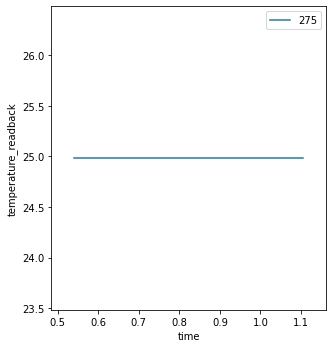

In [4]:
RE(bp.count([temperature], num=10))

Do all the readings look the same?  Perhaps there are only two different values (first one, then the other)?  That's because our measurements were only *reading* the temperature without waiting for it to update.  (If there are two different values, we caught the moment when EPICS updated the calculation.)  The table above showed `temperature_scanning_rate 5` which means the EPICS is only updating every 2 seconds.

In [5]:
temperature.scanning_rate.get(as_string=True)

'2 second'

## Adjust the measurement interval
We need to slow down the measurement to this interval by adding the `delay=2` kwarg, sampling every 2 seconds.



Transient Scan ID: 276     Time: 2021-02-24 13:10:22
Persistent Unique Scan ID: '5415661e-acbe-4169-8f8e-3e32ef158a0c'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 13:10:23.4 |             25.19480 |
|         2 | 13:10:25.3 |             24.65142 |
|         3 | 13:10:27.3 |             24.53989 |
|         4 | 13:10:29.3 |             25.10638 |
|         5 | 13:10:31.3 |             24.91205 |
|         6 | 13:10:33.3 |             25.12417 |
|         7 | 13:10:35.3 |             25.47929 |
|         8 | 13:10:37.3 |             24.86535 |
|         9 | 13:10:39.3 |             24.88807 |
|        10 | 13:10:41.3 |             25.23422 |
+-----------+------------+----------------------+
generator count ['5415661e'] (scan num: 276)


('5415661e-acbe-4169-8f8e-3e32ef158a0c',)

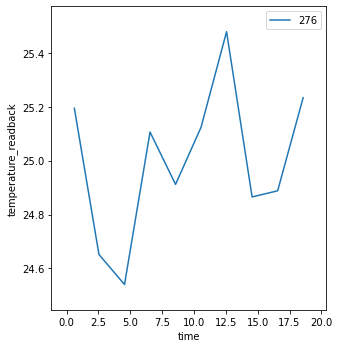

In [6]:
RE(bp.count([temperature], num=10, delay=2))

Let's reduce the update interval that EPICS uses, to the shortest interval EPICS provides, so our measurements do not take so long.

In [7]:
# print the list of possible values
print(temperature.scanning_rate.enum_strs)

# set the shortest interval, by name
temperature.scanning_rate.put(".1 second")
temperature.scanning_rate.get(as_string=True)

('Passive', 'Event', 'I/O Intr', '10 second', '5 second', '2 second', '1 second', '.5 second', '.2 second', '.1 second')


'2 second'

## Collect our measurements
Repeat the measurement, this time with more observations.

Also, we'll add a metadata key:value pair so that later we can find this data more easily in the database.  Most plans take a `md={}` kwarg where the value is a Python dictionary with the key:value pair(s) to add to the run's metadata.



Transient Scan ID: 277     Time: 2021-02-24 13:10:43
Persistent Unique Scan ID: 'd59bc603-a36f-464e-97f9-8811fb9e1c18'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 13:10:44.7 |             24.96903 |
|         2 | 13:10:44.8 |             24.95657 |
|         3 | 13:10:44.9 |             24.59616 |
|         4 | 13:10:45.0 |             25.10705 |
|         5 | 13:10:45.1 |             25.01920 |
|         6 | 13:10:45.2 |             24.61919 |
|         7 | 13:10:45.4 |             25.40517 |
|         8 | 13:10:45.5 |             25.28946 |
|         9 | 13:10:45.6 |             24.91001 |
|        10 | 13:10:45.7 |             25.22802 |
|        11 | 13:10:45.8 |             24.73493 |
|        12 | 13:10:45.9 |             24.83138 |
|        13 | 13:10:46.0 |             24.69046 |
|        14 | 13:10:46.1 |        

('d59bc603-a36f-464e-97f9-8811fb9e1c18',)

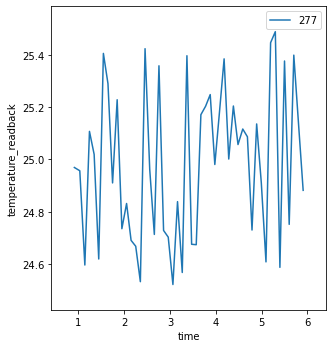

In [8]:
RE(bp.count([temperature], num=50, delay=0.1, md={"motive": "tscan"}))

## Get the data (from the database)
Let's get the measured data from the database now.  It's the most recent bluesky run, so an index of `-1` will identify it.

In [9]:
dataset = db.v2[-1].primary.read()

Let's get the values as a 1-D numpy array.

In [10]:
T = dataset["temperature_readback"].values

## Compute the statistics
Use the methods of numpy arrays to compute maximum, mean, standard deviation, and minimum.  Looks nicer in a table.

In [11]:
table = pyRestTable.Table()
table.addLabel("measure")
table.addLabel("value")
table.addRow(("max", T.max()))
table.addRow(("mean", T.mean()))
table.addRow(("dev", T.std()))
table.addRow(("min", T.min()))
table.addRow(("#", len(T)))
print(table)

======= ===================
measure value              
======= ===================
max     25.488204776073854 
mean    24.98401495384146  
dev     0.28772071844356367
min     24.52162203402762  
#       50                 
======= ===================



Let's replot that data for comparison.

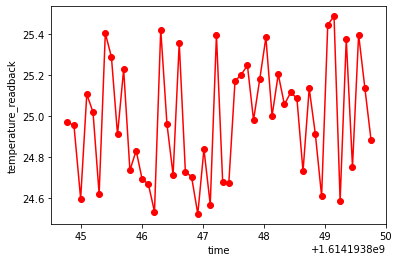

In [12]:
dataset["temperature_readback"].plot(marker="o", color="red")